# SVM based Sentiment Analysis
Let's perform a SVM based Sentiment Analysis based on Support a Vector Machine Model on Twitter Sentiments of US Airline passengers.


In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BlueFlames\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

## Import data


In [3]:
data = pd.read_csv("Tweets_Airline.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## We take only the tweets we are very confident with. We use the BeautifulSoup library to process html encoding present in some tweets.

In [4]:
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

In [5]:
data_clean['airline_sentiment']

0         neutral
2         neutral
3        negative
4        negative
5        negative
           ...   
14634    negative
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 13651, dtype: object

## For simplicity we are going to distinguish two cases: tweets with negative sentiment and tweets with non-negative sentiment

In [8]:
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 0 if x == 'negative' else 1)
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]
data_clean.head()

,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,1
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
5,@VirginAmerica seriously would pay $30 a fligh...,0


## We split the data into training and testing set:

In [9]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

## Preprocessing the Data

In [10]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

## We are going to use cross validation and grid search to find good hyperparameters for our SVM model. We need to build a pipeline.

In [12]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [15]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, 
                                             kernel= 'linear', 
                                             class_weight= 'balanced')) #Hint : Linear kernel with balanced class weights

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.8min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.8min finished


0.9188189903327681

In [16]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'svc__C': 0.1}
0.9026180171937629


## Let's see how the model (with the best hyperparameters) works on the test data:

In [17]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.9188223039171387,
 'f1': 0.7723169508525578,
 'acc': 0.8337605272793849,
 'precision': 0.7123034227567068,
 'recall': 0.8433734939759037}

## ROC Curve

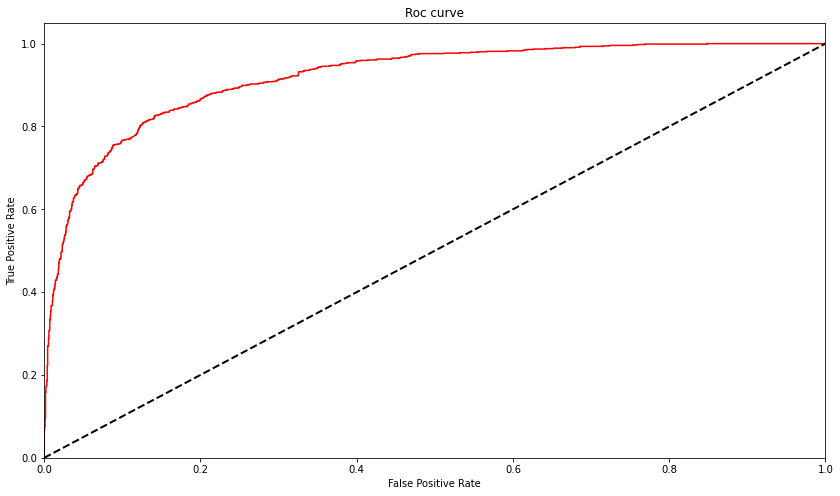

In [18]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

fpr, tpr = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

## Prediction

In [19]:
pred = grid_svm.predict(["flying with @united is always a great experience."])
print('negative' if pred == np.array([1]) else 'not negative')

negative


In [20]:
pred = grid_svm.predict(["flying with @united is always a great experience. If you don't lose your luggage"])
print('negative' if pred == np.array([1]) else 'not negative')

not negative


**It easily distinguishes the text based on context!!**